In [1]:
import numpy as np
from scipy.io import mminfo,mmread
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.linalg import eig
from numpy import sqrt, dot, sum, abs, diag, array, pi
from scipy import sparse

from numpy.fft import rfft, rfftfreq

import sys
np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(threshold=20)

Exercise 5 - Identification Techniques
===============================

This exercise is focused on identifying modal parameters from experiments.

Measurement data from a numerical impact hammer experiment on the plate supported by flexible springs is provided
in the file `measurement.txt`.
Time histories of acceleration at 24 points and of the force at the impact point were measured.
The point-coordinates are given in `measurement-coordinates.txt`.

You can load the data with
```python
from numpy import loadtxt
data = loadtxt('measurement.txt')
```

In [2]:
from numpy import loadtxt
data = loadtxt('measurement.txt')

* Plot the time history for the force as well as its frequency spectrum.

In [3]:
t = data[:,0] #Time vector
F = data[:,1] #Force vector

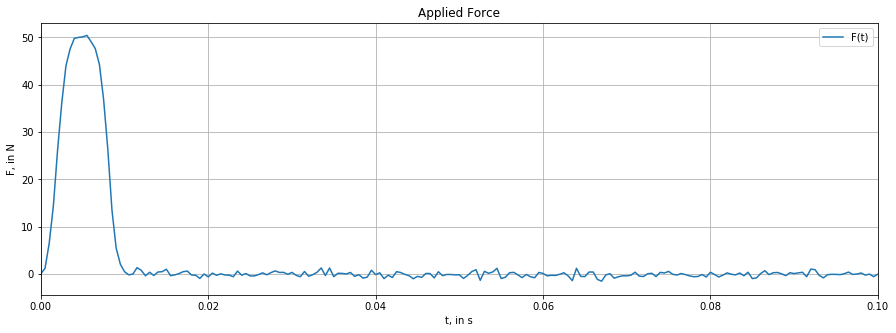

In [4]:
plt.figure(figsize = [15,5])
plt.plot(t,F,label = 'F(t)')
plt.xlabel('t, in s')
plt.ylabel('F, in N')
plt.title('Applied Force')
plt.xlim([0,0.1])
plt.legend()
plt.grid()

In [5]:
frequencies = rfftfreq(len(t),t[1] - t[0])
F_rfft = rfft(F)

* Plot the measured acceleration time histories and frequency spectra for the 4 corner points and the drive point (where the force is applied). Make sure to select appropriate time and frequency limits to only show useful data.

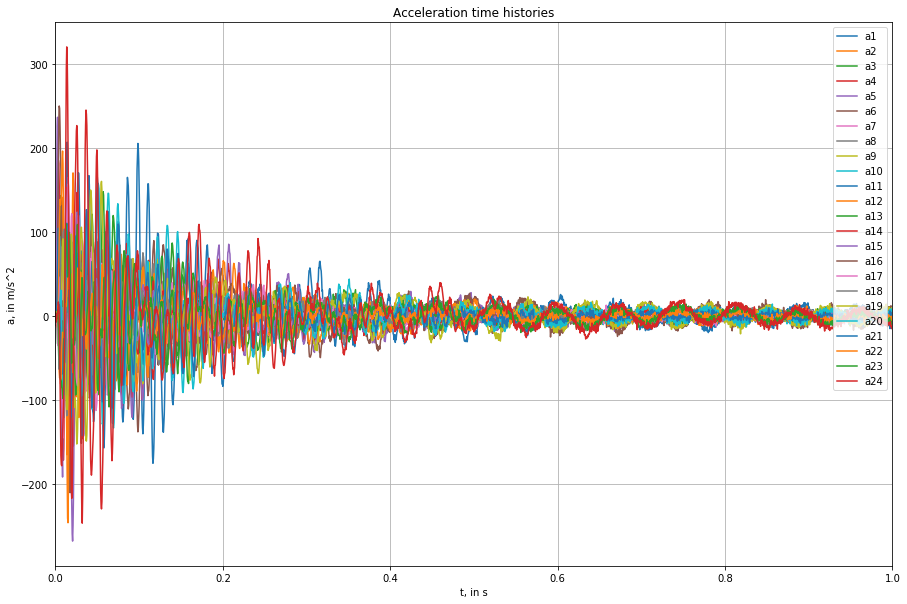

In [6]:
plt.figure(figsize = [15,10])
plt.xlabel('t, in s')
plt.ylabel('a, in m/s^2')
plt.title('Acceleration time histories')
plt.xlim([0,1])

for i in range(2,26) :
    plt.plot(t,data[:,i],label = 'a' + str(i-1))
    
plt.legend(loc = 1)
plt.grid()

Now we calculate the frequeny spectra of the 4 corner points. Form the Numerical Experiment Jupyter Notebook we acquire following information:
 * **P01** - Left lower corner
 * **P06** - Right lower corner
 * **P19** - Left top corner
 * **P24** - Right top corner
 
For the injection point of the force: **P05**

In [7]:
PO1_rfft = rfft(data[:,2])
PO6_rfft = rfft(data[:,7])
P19_rfft = rfft(data[:,20])
P24_rfft = rfft(data[:,25])

P05_rfft = rfft(data[:,6])

Now let's plot the frequency spectra

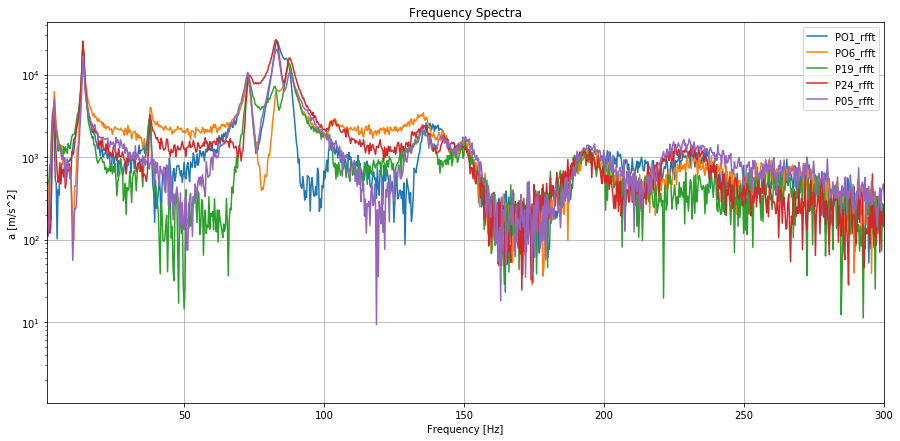

In [8]:
plt.figure(figsize = [15,7])

plt.semilogy(frequencies,np.abs(PO1_rfft), label='PO1_rfft')
plt.semilogy(frequencies,np.abs(PO6_rfft), label='PO6_rfft')
plt.semilogy(frequencies,np.abs(P19_rfft), label='P19_rfft')
plt.semilogy(frequencies,np.abs(P24_rfft), label='P24_rfft')
plt.semilogy(frequencies,np.abs(P05_rfft), label='P05_rfft')

plt.ylabel('a [m/s^2]')
plt.xlabel('Frequency [Hz]')
plt.xlim(1,300)
plt.title('Frequency Spectra')
plt.legend()
plt.grid()

* Compute the accelerance and plot it for the drive point. 

Make sure to apply a suitable window to the data, to counteract the effect of poor signal to noise ratio in parts of the singal.
For decaying signal a decaring exponential window is suitable, e.g. use
```python
from scipy.signal import windows
frac = 1e-3 # choose something useful
W = windows.exponential(len(t), 0, -(len(t)-1) / np.log(frac), False)
```
Multiply the window to the data, before you do the FFT.


In [9]:
from scipy.signal import windows
frac = 5e-3 # choose something useful
W = windows.exponential(len(t), 0, -(len(t)-1) / np.log(frac), False)

Let's first compare for one point how the window function influences the acceleration

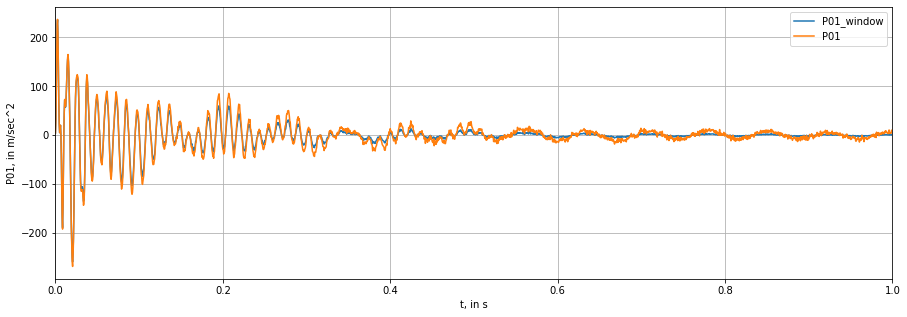

In [10]:
plt.figure(figsize = [15,5])
plt.plot(t,data[:,6]*W, label = "P01_window")
plt.plot(t,data[:,6], label = "P01")
plt.xlabel('t, in s')
plt.ylabel('P01, in m/sec^2')
plt.xlim([0,1])
plt.legend()
plt.grid()

In [11]:
PO1_rfft_window = rfft(data[:,2]*W)
PO6_rfft_window = rfft(data[:,7]*W)
P19_rfft_window = rfft(data[:,20]*W)
P24_rfft_window = rfft(data[:,25]*W)

P05_rfft_window = rfft(data[:,6]*W)

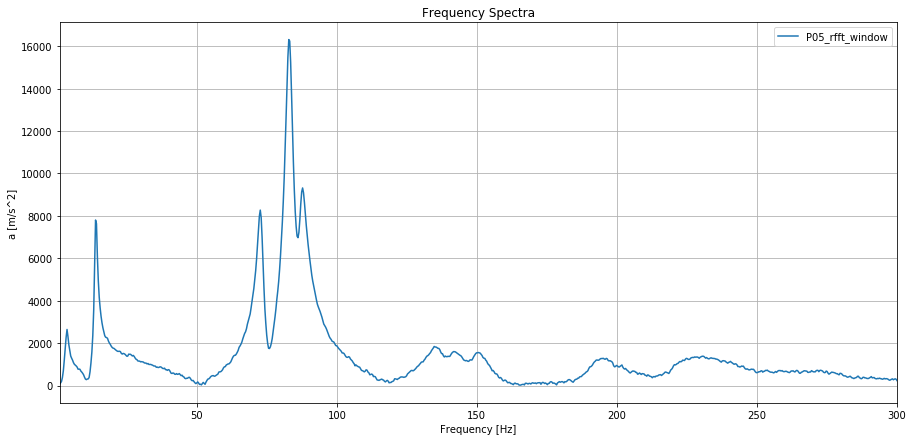

In [12]:
plt.figure(figsize = [15,7])

# plt.semilogy(frequencies,np.abs(PO1_rfft_window), label='PO1_rfft_window')
# plt.semilogy(frequencies,np.abs(PO6_rfft_window), label='PO6_rfft_window')
# plt.semilogy(frequencies,np.abs(P19_rfft_window), label='P19_rfft_window')
# plt.semilogy(frequencies,np.abs(P24_rfft_window), label='P24_rfft_window')
plt.plot(frequencies,np.abs(P05_rfft_window), label='P05_rfft_window')

plt.ylabel('a [m/s^2]')
plt.xlabel('Frequency [Hz]')
plt.xlim(1,300)
plt.title('Frequency Spectra')
plt.legend()
plt.grid()

* Compute the receptance from the accelerance and plot it for the drive point.

In [13]:
P05_receptance = rfft(data[:,6]*W)/rfft(data[:,1]*W)

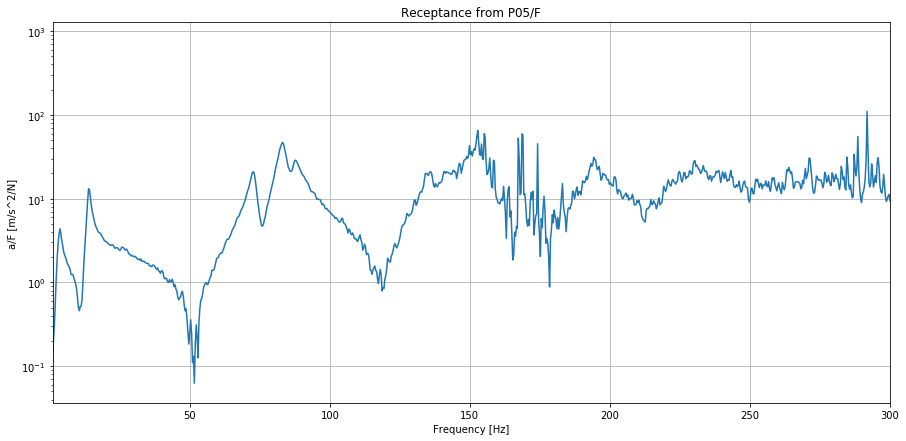

In [14]:
plt.figure(figsize = [15,7])

plt.semilogy(frequencies,np.abs(P05_receptance))

plt.ylabel('a/F [m/s^2/N]')
plt.xlabel('Frequency [Hz]')
plt.xlim(1,300)
plt.title('Receptance from P05/F')
plt.grid()

## Task1: Find Peaks in the Transfer Functions
Use the Maximum Amplitude, Maximum Quadrature or Maximum Quadrature Component method to find all natural frequencies up to 150Hz.

For low frequency peaks it might be best to look at receptance curves, wheras for high frequenies the peaks in the accelerance might be more pronounced.
Some automatic peak finding algorithms are implemented in scipy. 
A useful and rather robust automatic peak-detection tool is the continuous wavelet transform, e.g. use
```python
from scipy.signal import find_peaks, find_peaks_cwt
```
Often the automatic selection has to be fine tuned by hand.

* Use an automatic tool to detect peaks in the drive-point accelerance, and plot the found peaks.
* Then adapt the result by hand (add shift peaks) until you have found all natural frequencies.
* Plot the magnitude, real and imaginary part of the fransfer functions around each peak in a suitable frequency range (~10Hz) to verify the peak location: all transfer functions in one plot, one plot per part, one plot per peak

In [15]:
from scipy.signal import find_peaks, find_peaks_cwt

In [16]:
# Use an automatic tool to detect peaks in the drive-point accelerance
peaks_idx_P05_rfft_window, _ = find_peaks(np.abs(P05_rfft_window), height=2000) 
# The height is set so that only realistic peaks are taken into account

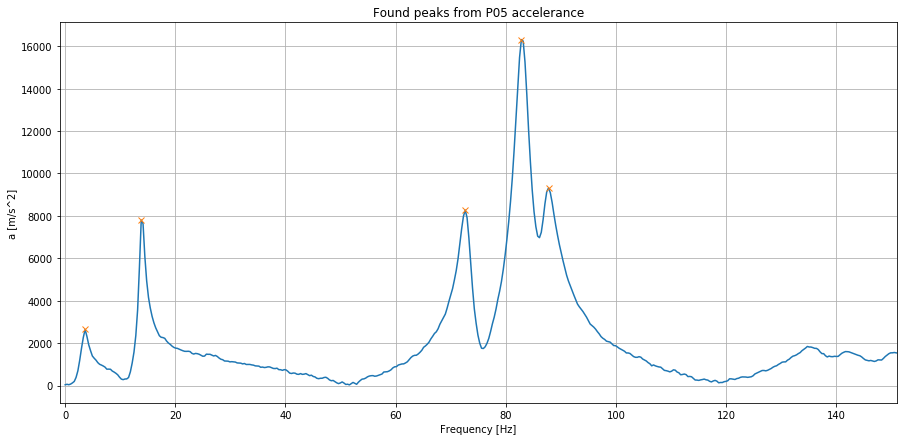

In [17]:
plt.figure(figsize = [15,7])
plt.ylabel('a [m/s^2]')
plt.xlabel('Frequency [Hz]')
plt.xlim(-1,151)
plt.title('Found peaks from P05 accelerance')
plt.grid()
plt.plot(frequencies, np.abs(P05_rfft_window))
plt.plot(frequencies[peaks_idx_P05_rfft_window], np.abs(P05_rfft_window)[peaks_idx_P05_rfft_window], 'x')
plt.show()

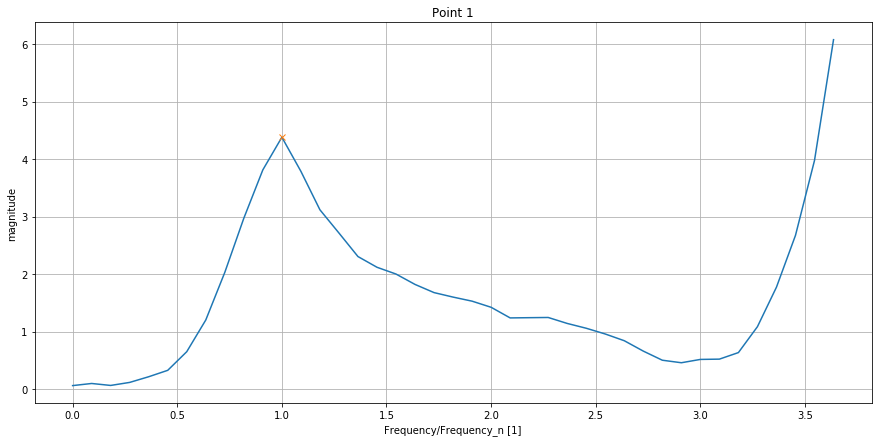

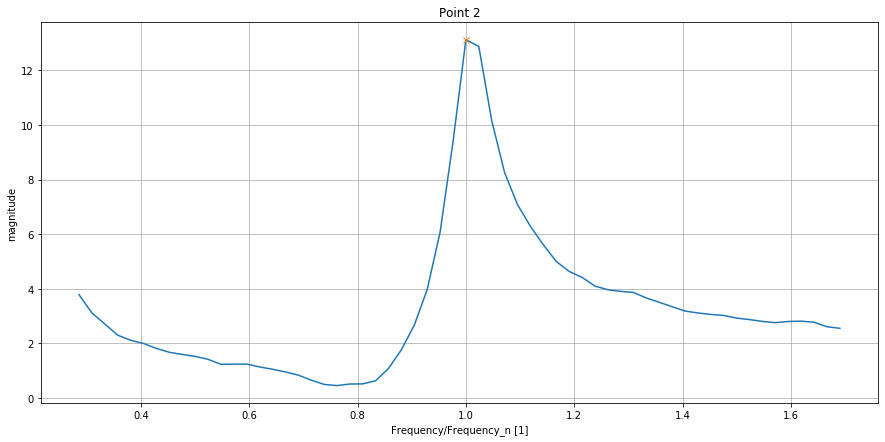

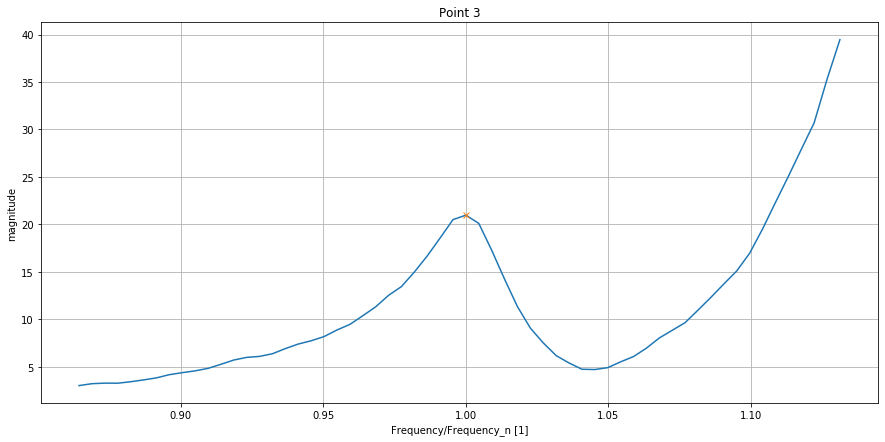

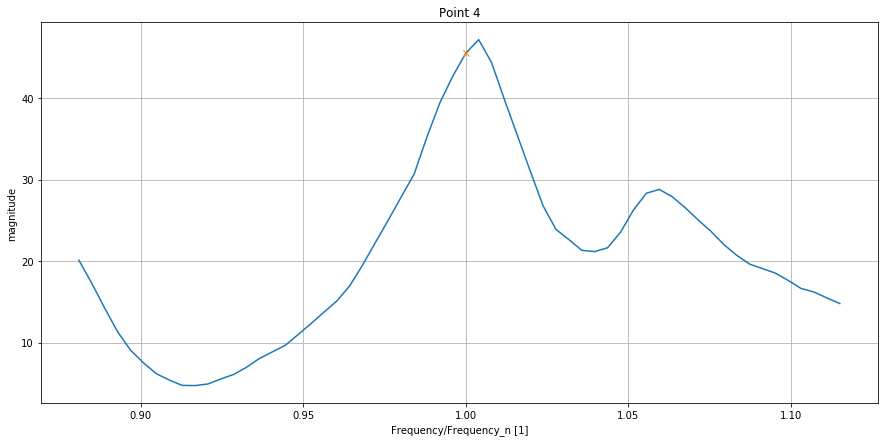

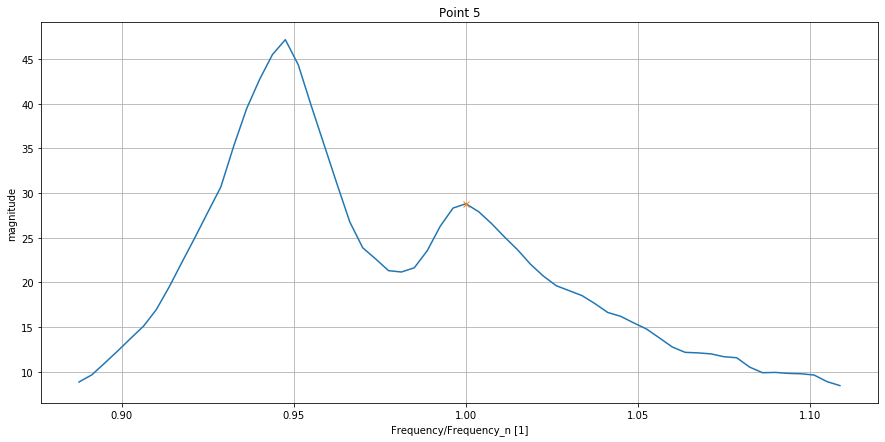

In [18]:
# Plot the magnitude
bound = 10;

for n,i in enumerate(peaks_idx_P05_rfft_window):
    plt.figure(figsize = [15,7])

    lower_freq = frequencies[i]-bound
    upper_freq = frequencies[i]+bound
    
    lower_idx = (np.abs(frequencies - lower_freq)).argmin()
    upper_idx = (np.abs(frequencies - upper_freq)).argmin()
    
    plt.plot(frequencies[lower_idx:upper_idx]/frequencies[i], np.abs(P05_receptance[lower_idx:upper_idx]))
    plt.plot(frequencies[i]/frequencies[i], np.abs(P05_receptance[i]), 'x')
    
    plt.ylabel('magnitude')
    plt.xlabel('Frequency/Frequency_n [1]')
    plt.title('Point '+ str(n+1))
    plt.grid()

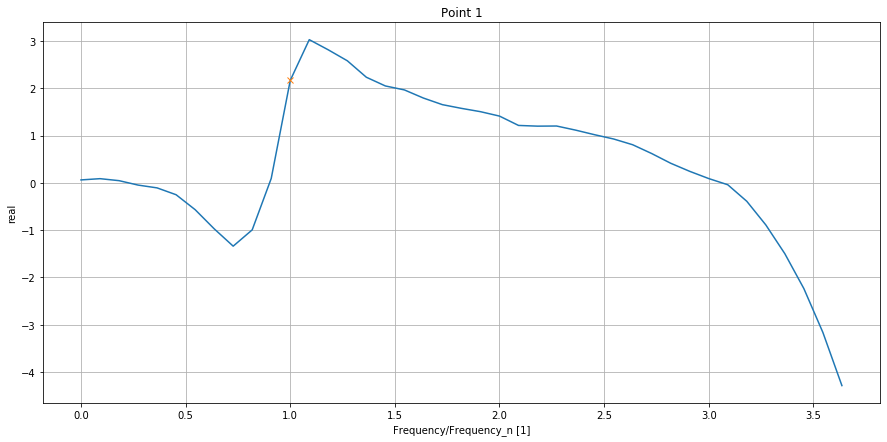

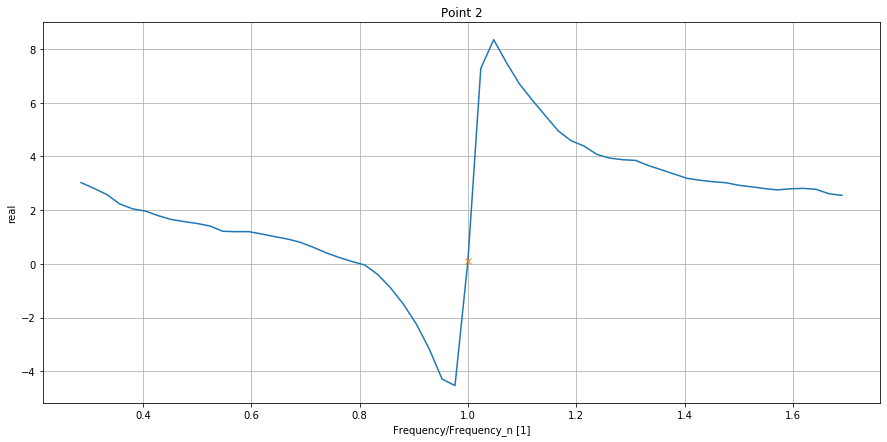

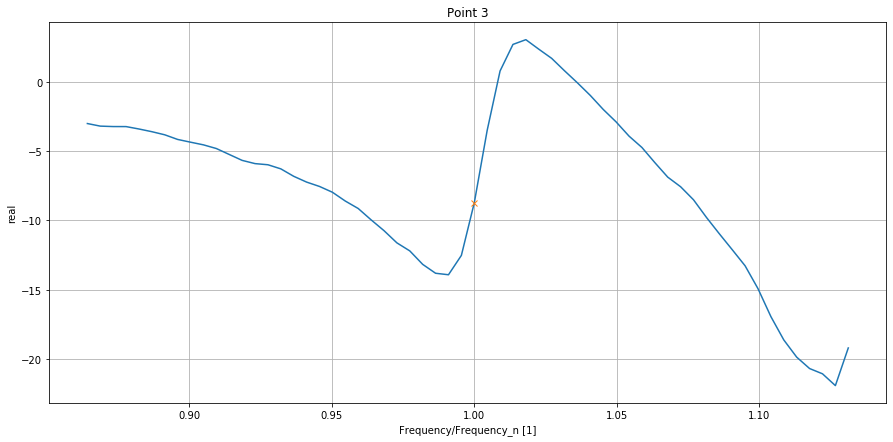

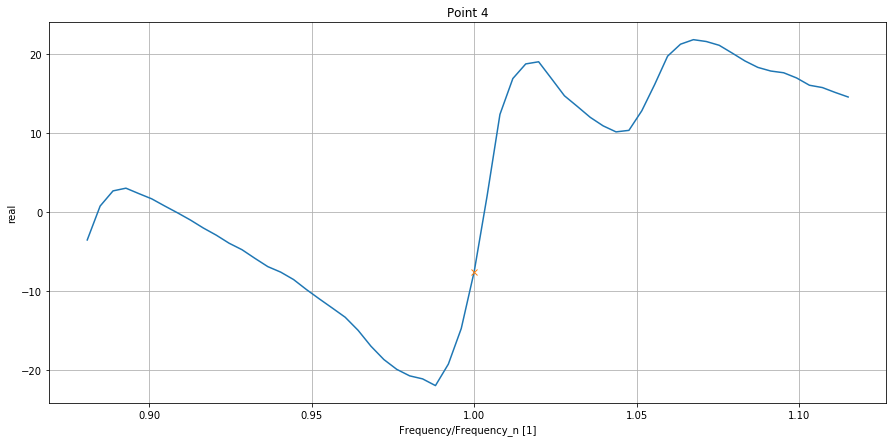

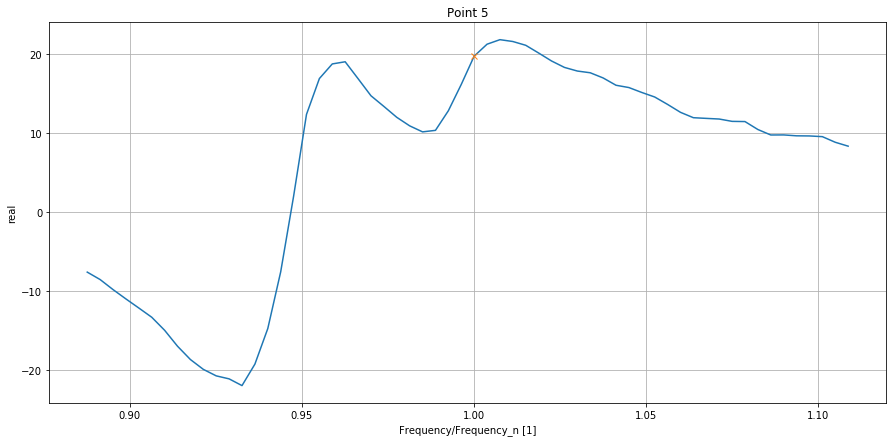

In [19]:
# Plot the real part
for n,i in enumerate(peaks_idx_P05_rfft_window):
    plt.figure(figsize = [15,7])

    lower_freq = frequencies[i]-bound
    upper_freq = frequencies[i]+bound
    
    lower_idx = (np.abs(frequencies - lower_freq)).argmin()
    upper_idx = (np.abs(frequencies - upper_freq)).argmin()
    
    plt.plot(frequencies[lower_idx:upper_idx]/frequencies[i], np.real(P05_receptance[lower_idx:upper_idx]))
    plt.plot(frequencies[i]/frequencies[i], np.real(P05_receptance[i]), 'x')
    
    plt.ylabel('real')
    plt.xlabel('Frequency/Frequency_n [1]')
    plt.title('Point '+ str(n+1))
    plt.grid()

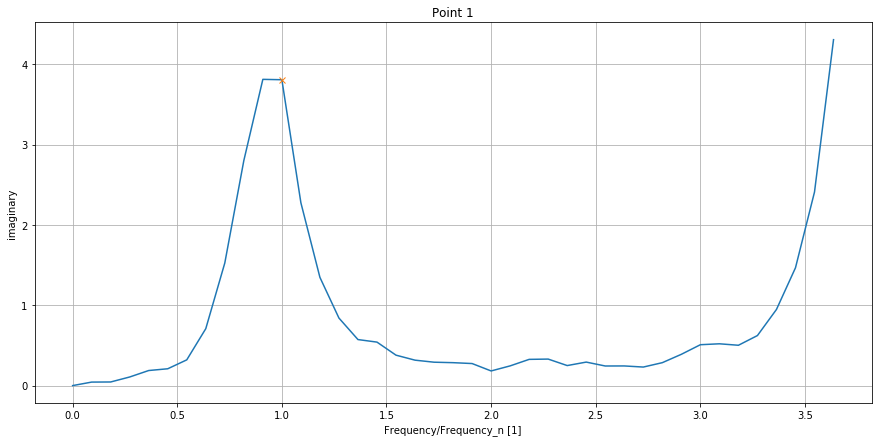

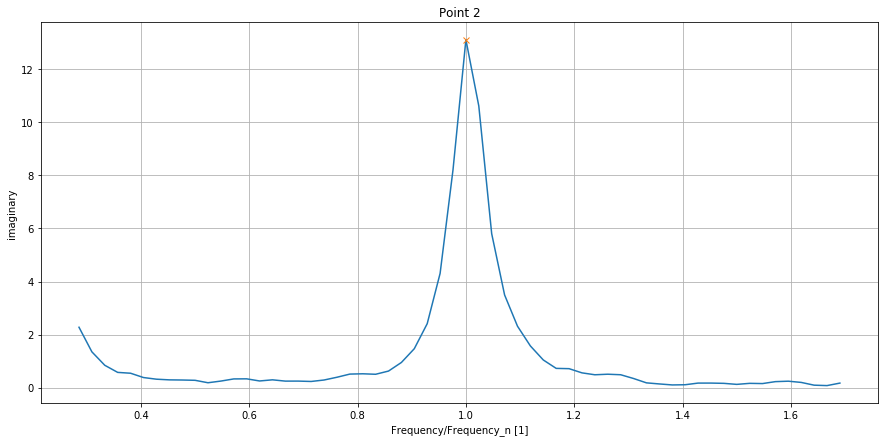

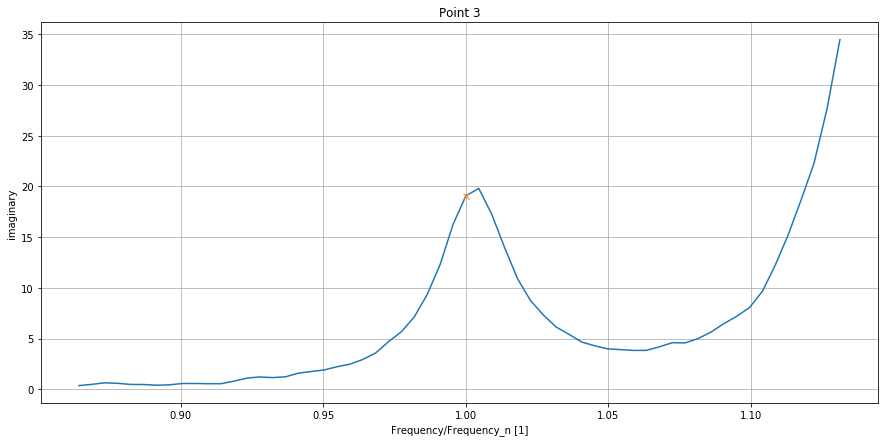

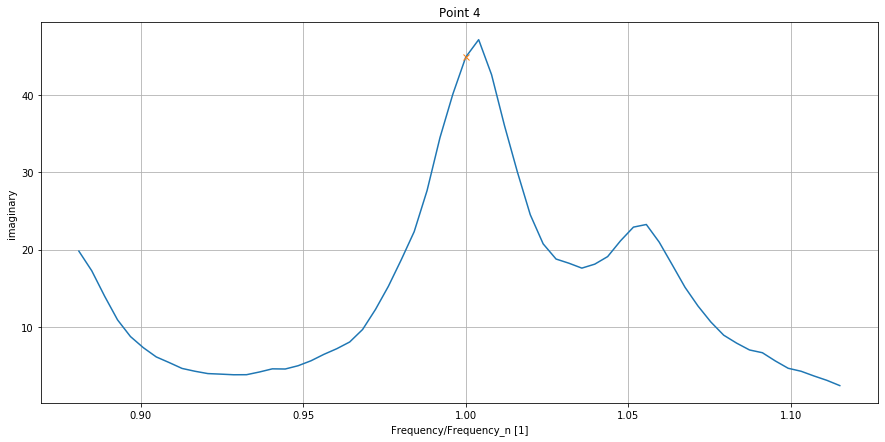

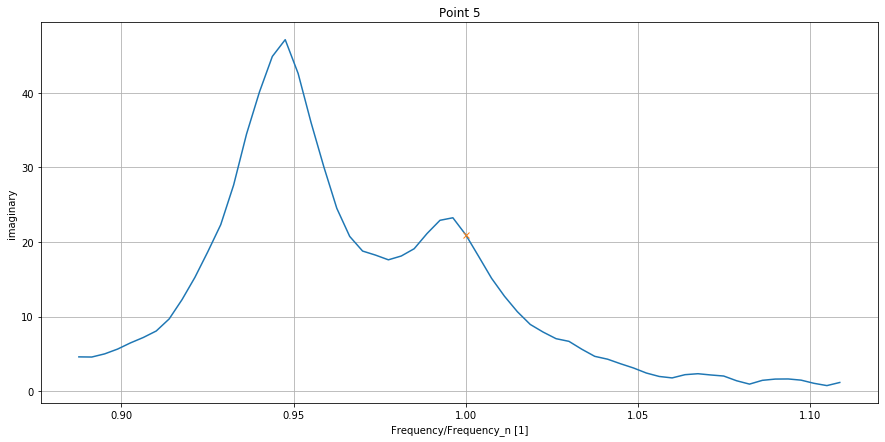

In [20]:
# Plot the imaginary part
for n,i in enumerate(peaks_idx_P05_rfft_window):
    plt.figure(figsize = [15,7])

    lower_freq = frequencies[i]-bound
    upper_freq = frequencies[i]+bound
    
    lower_idx = (np.abs(frequencies - lower_freq)).argmin()
    upper_idx = (np.abs(frequencies - upper_freq)).argmin()
    
    plt.plot(frequencies[lower_idx:upper_idx]/frequencies[i], np.imag(P05_receptance[lower_idx:upper_idx]))
    plt.plot(frequencies[i]/frequencies[i], np.imag(P05_receptance[i]), 'x')
    
    plt.ylabel('imaginary')
    plt.xlabel('Frequency/Frequency_n [1]')
    plt.title('Point '+ str(n+1))
    plt.grid()

In [21]:
print('Peaks:', frequencies[peaks_idx_P05_rfft_window], 'Hz')

Peaks: [ 3.61604208 13.80670611 72.64957265 82.84023669 87.77120316] Hz


## Determine Damping Ratio
Determine the damping ratio of each natural frequency from the half power width.
Use the drive point receptance.

* plot the determined half power points on the transfer function for each peak

In [22]:
half_power = np.abs(P05_receptance)/sqrt(2) #
print('Half power magnitude:', half_power[peaks_idx_P05_rfft_window])

Half power magnitude: [ 3.09696453  9.27648256 14.83334402 32.17955407 20.36792258]


In [23]:
# find out to which index the half power points belong
index_half_power = np.zeros([len(peaks_idx_P05_rfft_window), 4],dtype = int)

for n,idx in enumerate(peaks_idx_P05_rfft_window):
    for i in range(idx, 0, -1):
        if half_power[idx] >= np.abs(P05_receptance)[i]:
            index_half_power[n,0] = i
            index_half_power[n,1] = i+1
            break

    for i in range(idx, len(frequencies)+1, 1):
        if half_power[idx] >= np.abs(P05_receptance)[i]:
            index_half_power[n,3] = i
            index_half_power[n,2] = i-1
            break

# linear interpolation between between the values found
freq_half_power = np.zeros([len(peaks_idx_P05_rfft_window),2])
    
for n,a in enumerate(index_half_power):
        freq_half_power[n,0] = ((frequencies[a[1]]-frequencies[a[0]])/
                                (np.abs(P05_receptance)[a[1]]-
                                 np.abs(P05_receptance)[a[0]]
                                ))*(half_power[peaks_idx_P05_rfft_window[n]]-np.abs(P05_receptance)[a[0]])+frequencies[a[0]]
        freq_half_power[n,1] = ((frequencies[a[3]]-frequencies[a[2]])/
                                (np.abs(P05_receptance)[a[3]]-
                                 np.abs(P05_receptance)[a[2]]
                                ))*(half_power[peaks_idx_P05_rfft_window[n]]-np.abs(P05_receptance)[a[2]])+frequencies[a[2]]

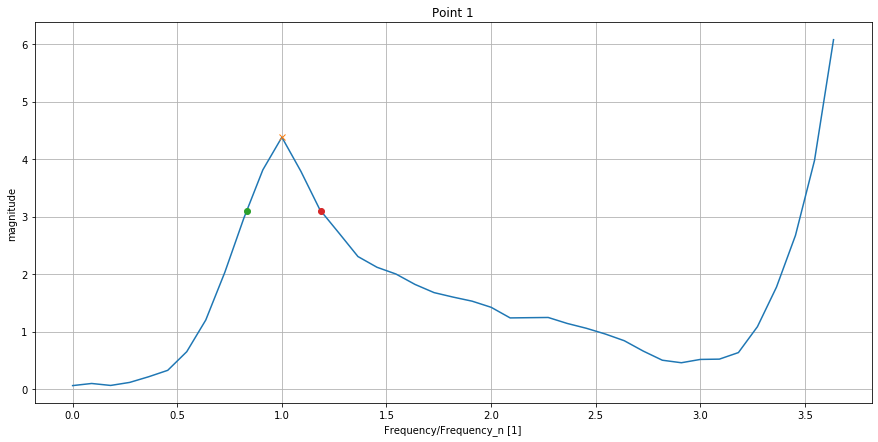

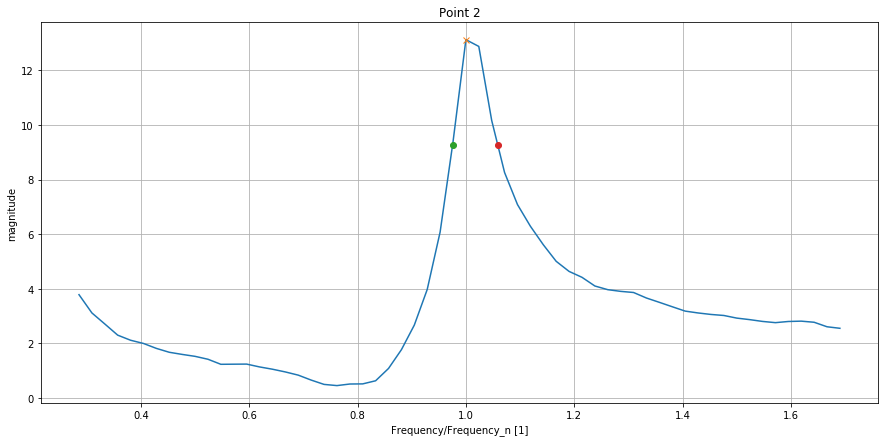

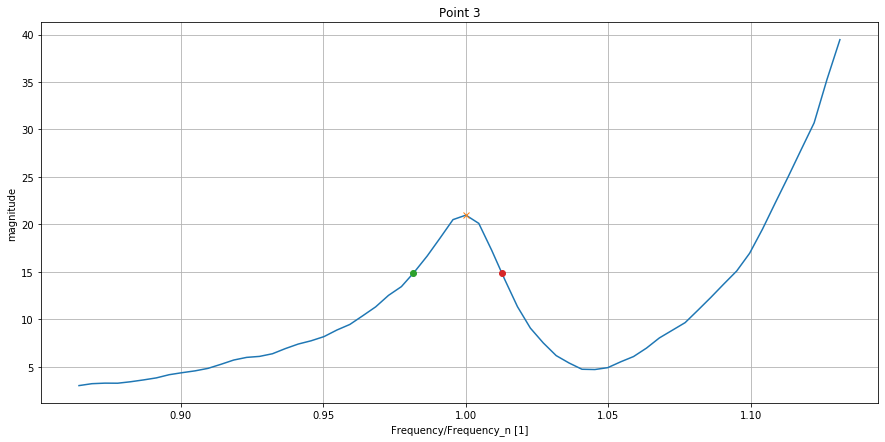

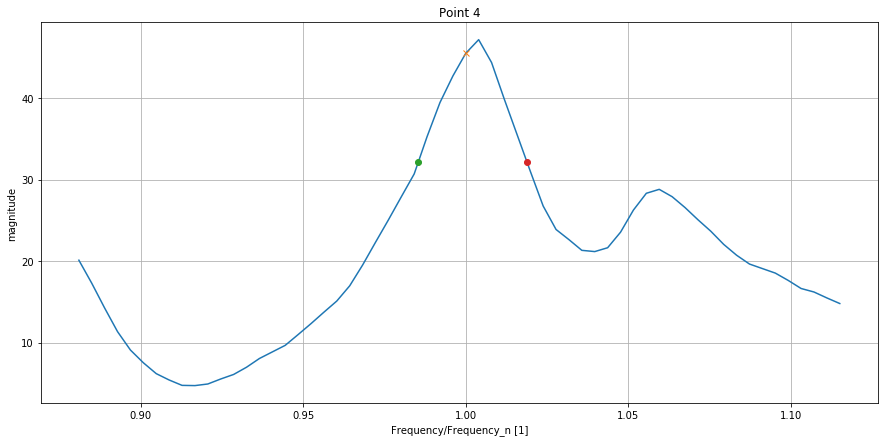

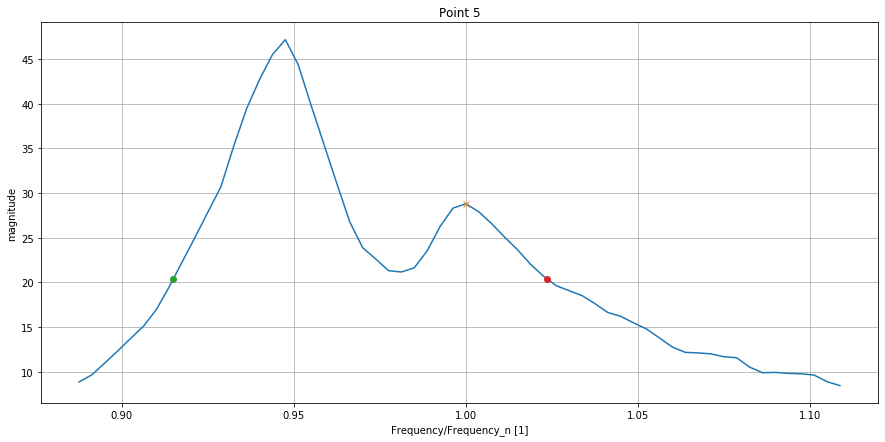

In [24]:
# Plot the magnitude  
for n,i in enumerate(peaks_idx_P05_rfft_window):
    plt.figure(figsize = [15,7])

    lower_freq = frequencies[i]-bound
    upper_freq = frequencies[i]+bound
    
    lower_idx = (np.abs(frequencies - lower_freq)).argmin()
    upper_idx = (np.abs(frequencies - upper_freq)).argmin()
    
    plt.plot(frequencies[lower_idx:upper_idx]/frequencies[i], np.abs(P05_receptance[lower_idx:upper_idx]))
    plt.plot(frequencies[i]/frequencies[i], np.abs(P05_receptance[i]), 'x')
    plt.plot(freq_half_power[n,0]/frequencies[i], half_power[i], 'o')
    plt.plot(freq_half_power[n,1]/frequencies[i], half_power[i], 'o')
    
    plt.ylabel('magnitude')
    plt.xlabel('Frequency/Frequency_n [1]')
    plt.title('Point '+ str(n+1))
    plt.grid()

* what damping factors do you obtain?

In [25]:
# Damping factor
Damping_factor = (freq_half_power[:,1]-freq_half_power[:,0])/(2*frequencies[peaks_idx_P05_rfft_window])

print('Damping Factors: ', Damping_factor)

Damping Factors:  [0.17744339 0.04160639 0.01560504 0.01669981 0.05433805]


## Circle Fitting
Employ the circle fitting algorithm to determine natural frequencies and damping factors.

* Develop a function that fits a circle in the nyquist plane to given data points (receptance values and corresponding frequencies). It should return the natural frequency, damping factor and complex valued modal constant.

In [55]:
def CircleFitting(receptance,w,printFlag = 0) :
    x = np.real(receptance)
    y = np.imag(receptance)
    
    ## DO CIRCLE FITTING STUFF TO THE DATA
    L = len(x)
    A = np.zeros((3,3))
    
    A[0,0] = np.sum(x*x)
    A[1,1] = np.sum(y*y)
    A[2,2] = L
    
    A[0,1] = A[1,0] = np.sum(x*y)
    A[0,2] = A[2,0] = -np.sum(x)
    A[1,2] = A[2,1] = -np.sum(y)
    
    B = np.zeros((3,1))
    B[0] = -np.sum(x*x*x)-np.sum(x*y*y)
    B[1] = -np.sum(y*y*y)-np.sum(x*x*y)
    B[2] = np.sum(x*x)+np.sum(y*y)
    
    sol = np.linalg.solve(A,B)
    
    ## CIRCLE DATA
    xk = -1/2*sol[0]
    yk = -1/2*sol[1]
    Rk = np.sqrt(sol[2] + xk**2 + yk**2)
    
    # Generate spokes for plotting
    pointers_x = x - xk
    pointers_y = y - yk
    
    frequency_spacing = np.zeros((len(pointers_x)-1))
    
    ## CALCULATE ANGLES BETWEEN SPOKES
    for i in range(0,len(pointers_x)-1) :
        pointer_1 = np.array((pointers_x[i],pointers_y[i]))
        pointer_2 = np.array((pointers_x[i+1],pointers_y[i+1]))
        frequency_spacing[i] = np.arccos(np.dot(pointer_1,pointer_2)/np.linalg.norm(pointer_1)/np.linalg.norm(pointer_2))
    
    ## CALCULATE GRADIENT
    dg_dw = np.gradient(frequency_spacing,w[0:-1])
    d2g_dw2 = np.gradient(dg_dw,w[0:-1])
    max_idx = dg_dw.argmax() + 2 #find out why we need to shift by 2
    
    ## FIND wk
    wk = w[max_idx]
    wa = w[max_idx+1]
    wb = w[max_idx-1]
    
    x_wk = x[max_idx]
    y_wk = y[max_idx]
    x_Dk = 2*xk - x_wk
    y_Dk = 2*yk - y_wk
    
    # FIND Dk
    Dk = np.complex(x_Dk,y_Dk)
    
    # Generate spokes from Dk
    pointers2_x = x - x_Dk
    pointers2_y = y - y_Dk
    
    pointer_1 = np.array((pointers2_x[max_idx],pointers2_y[max_idx])) #k
    pointer_2 = np.array((pointers2_x[max_idx+1],pointers2_y[max_idx+1])) #a
    pointer_3 = np.array((pointers2_x[max_idx-1],pointers2_y[max_idx-1])) #b
    pointer_down = np.array((0, y_wk))
    
    ## CALCULATE Phi_a / ...
    Phi_a = np.arccos(np.dot(pointer_1,pointer_2)/np.linalg.norm(pointer_1)/np.linalg.norm(pointer_2))
    Phi_b = np.arccos(np.dot(pointer_1,pointer_3)/np.linalg.norm(pointer_1)/np.linalg.norm(pointer_3))
    Phi_k = np.arccos(np.dot(pointer_1,pointer_down)/np.linalg.norm(pointer_1)/np.linalg.norm(pointer_down))
    
    zeta_k = (wa**2 - wb**2)/2/wk**2/(np.tan(Phi_a) + np.tan(Phi_b))
    C_k = 4*Rk*wk**2*zeta_k*np.exp(1j*Phi_k)
    
    H_w = C_k/(wk**2 - w*w + 2*1j*wk*zeta_k*w) + Dk
    
    if printFlag == 1 :
        theta = np.linspace(0,2*np.pi,100)
        x_circle = Rk*np.cos(theta) + xk
        y_circle = Rk*np.sin(theta) + yk

        plt.figure(figsize = [15,7])
        plt.plot(x,y,label = 'data')
        plt.plot(x_circle,y_circle, '--', label = 'circle fit')
        plt.plot(xk,yk, 'o',label = 'center', markersize=10)
        plt.plot(x_wk,y_wk, 'x',label = 'w_k', markersize=10)
        plt.plot(x_Dk,y_Dk,'d',label = 'D_k', markersize=10)
        
        plt.plot([x_Dk,x[max_idx+1]],[y_Dk,y[max_idx+1]],'--')
        plt.plot([x_Dk,x[max_idx-1]],[y_Dk,y[max_idx-1]],'--')
        plt.plot([x_Dk,x[max_idx]],[y_Dk,y[max_idx]],'--')
        plt.plot([x_Dk, x_Dk], [y_Dk, y_Dk + y_wk])

#         for i,idx in enumerate(pointers_x) :
#             plt.plot([xk,x[i]],[yk,y[i]],'--')
        
        plt.title('Circle Fitting, wk = ' + str(wk))
        plt.ylabel('imag(H(w))')
        plt.xlabel('real(H(w))')
        plt.legend()
        plt.axis('equal')
        plt.grid()  
        
        plt.figure(figsize = [15,7])
        plt.plot(w,np.abs(receptance), label = 'measured recepetance')
        plt.plot(w,np.abs(H_w),label = 'circle fit')
        plt.xlabel('frequencies [Hz]')
        plt.ylabel('abs(H(w))')
        plt.title('Receptance')
        plt.grid()
        plt.legend()
        plt.show()

#         plt.figure()
#         plt.plot(w[0:-1],frequency_spacing)
#         plt.show()

#         plt.figure
#         plt.plot(w[0:-1],dg_dw)
#         plt.show()

#         plt.figure
#         plt.plot(w[0:-1],d2g_dw2)
#         plt.show()
        
    return wk, zeta_k, C_k[0], Dk, H_w

* First test your function on a nice, prominant peak of the drive point receptance (e.g. around 73Hz): Select suitable data points (frequency range) for the fit. Plot your fit in the Nyquist plane. Also plot the transfer function estimation by the cicle fit, i.e. $$ H(\omega) = \frac{C_k}{\omega_k^2 - \omega^2 + 2j \omega_k\zeta_k\omega}+D_k$$ in a wider frequency range, and compare it to the data to see how the fit performs.

* Use your function and determine suitable frequency ranges to fit all natural frequencies. For some it might be useful to switch to a different transfer function, where the peak under consideration is more prominant.

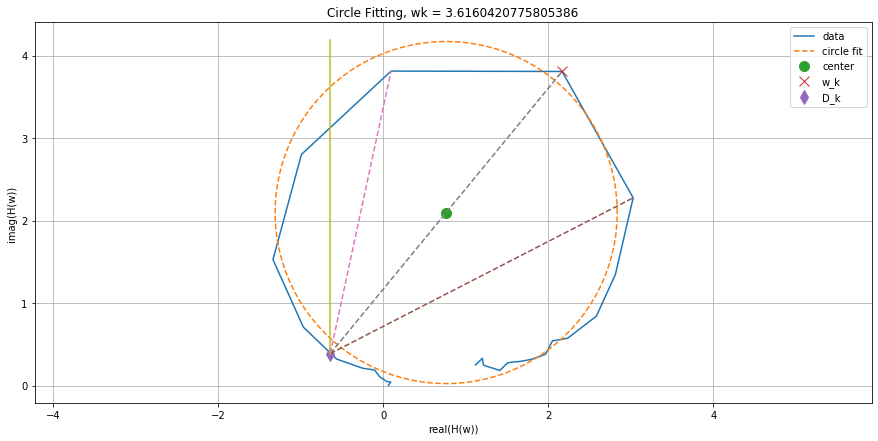

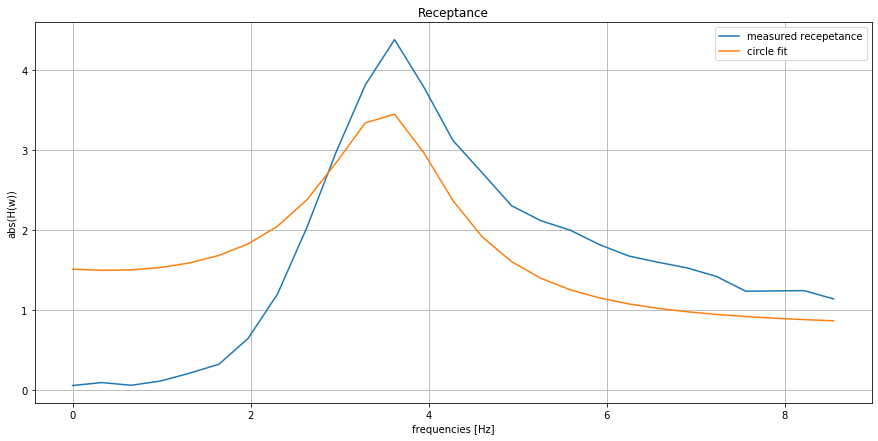

------------------------- Peak 0-------------------------
Natural Frequency:  3.6160420775805386
Damping Factor:  0.1918775854275148
Modal Constant:  (16.079689996116198+13.21315010263125j)



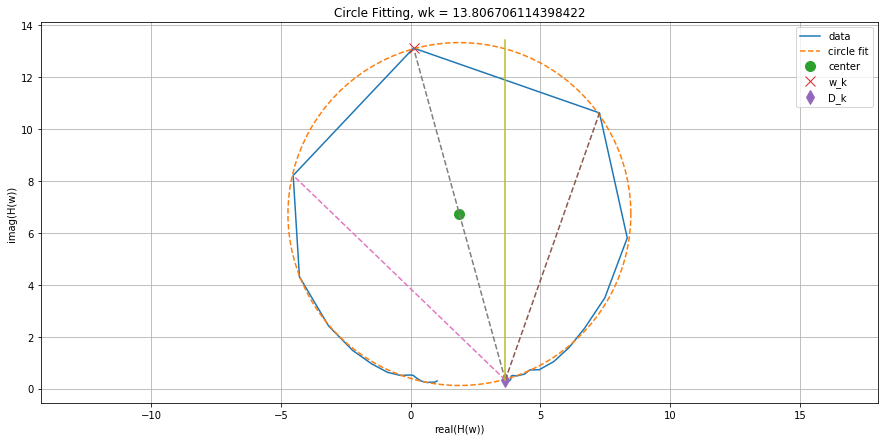

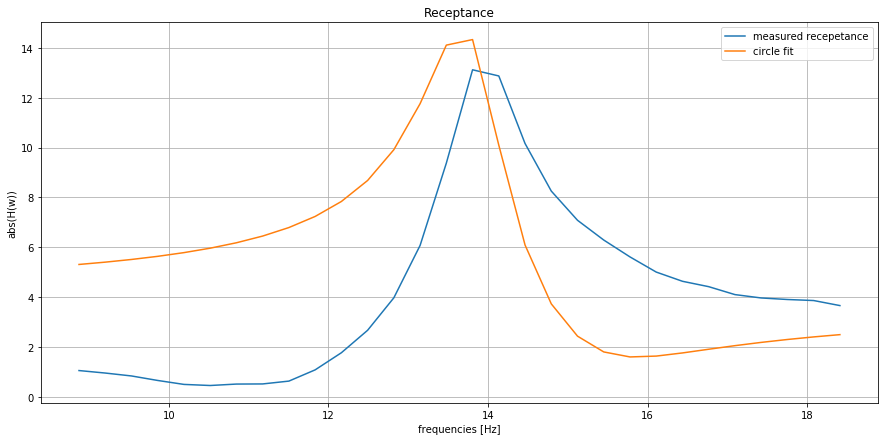

------------------------- Peak 1-------------------------
Natural Frequency:  13.806706114398422
Damping Factor:  0.03696720118812689
Modal Constant:  (179.5366591266318+49.601043674893866j)



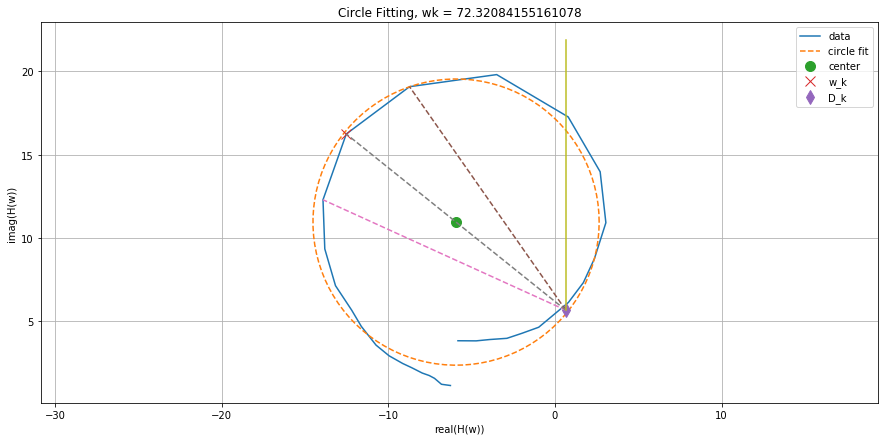

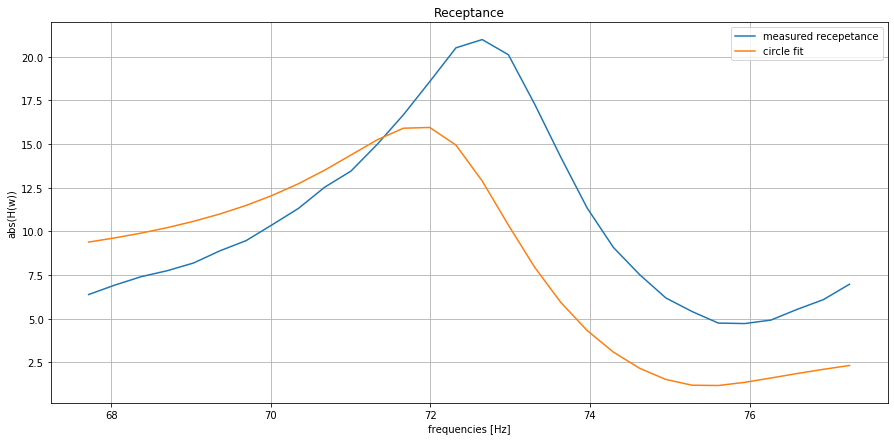

------------------------- Peak 2-------------------------
Natural Frequency:  72.32084155161078
Damping Factor:  0.016618350078493622
Modal Constant:  (1868.5981025176138+2328.1510147079625j)



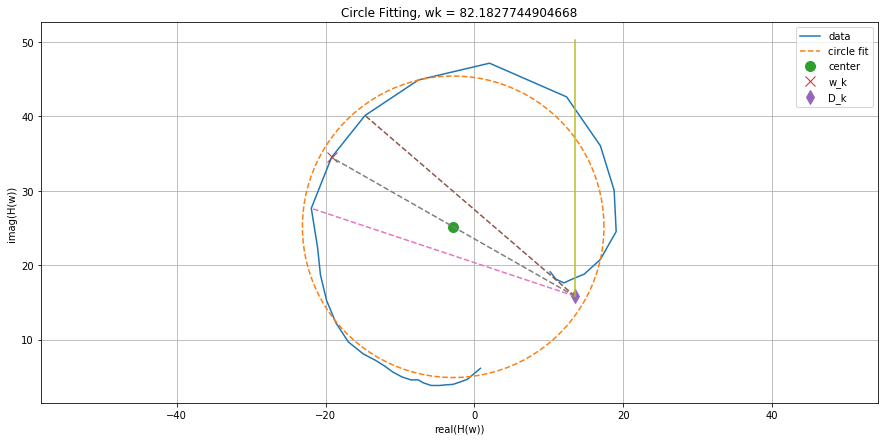

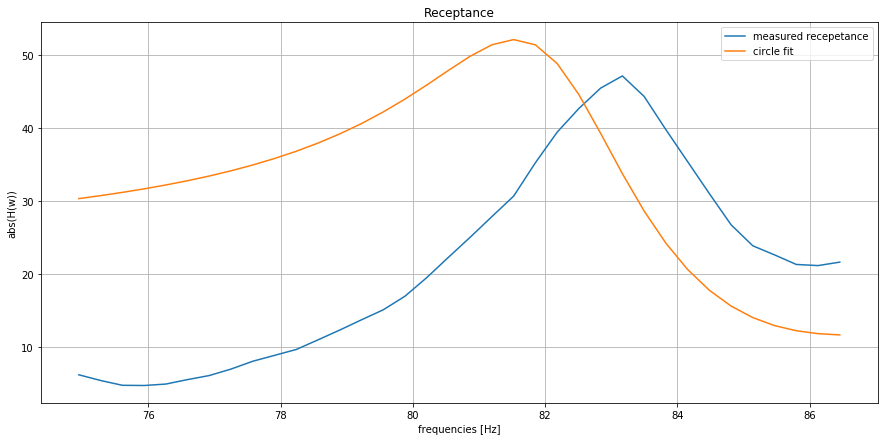

------------------------- Peak 3-------------------------
Natural Frequency:  82.1827744904668
Damping Factor:  0.020300234273305615
Modal Constant:  (5502.437150753916+9654.354102035939j)



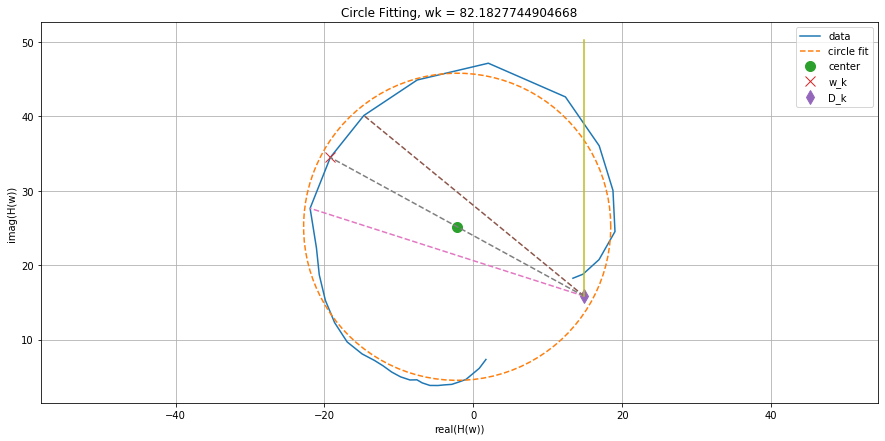

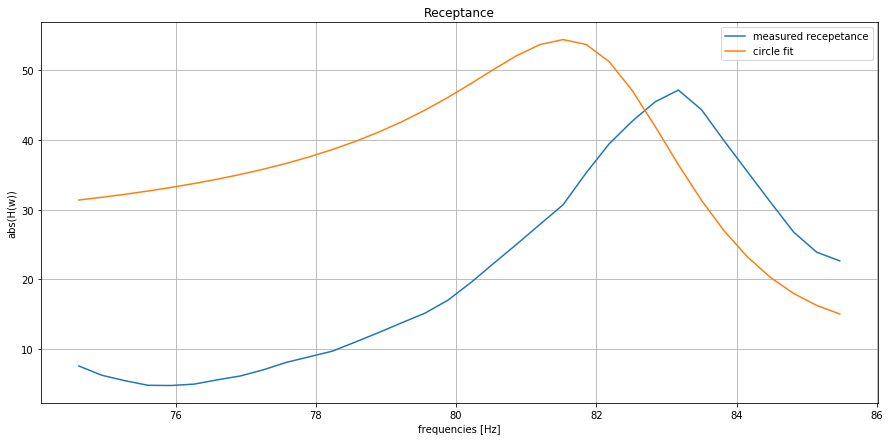

------------------------- Peak 4-------------------------
Natural Frequency:  82.1827744904668
Damping Factor:  0.02098236244144998
Modal Constant:  (5611.172330877944+10265.698842033571j)



In [56]:
frequency_indexes = np.array([[0,27],
                             [27,57],
                             [206,236],
                             [228,264],
                             [227,261]
                             ])

wk_all = np.zeros(len(frequency_indexes), dtype = float)
zeta_k_all = np.zeros(len(frequency_indexes), dtype = float)
C_k_all = np.zeros(len(frequency_indexes), dtype = complex)
D_k_all = np.zeros(len(frequency_indexes), dtype = complex)
H_w_all = np.zeros((len(frequency_indexes),len(frequencies)), dtype = complex)

for i,v in enumerate(frequency_indexes) :
    lower_idx = v[0]
    upper_idx = v[1]

    w = frequencies[lower_idx:upper_idx]
    receptance = P05_receptance[lower_idx:upper_idx]

    # Toggle plots ON/Off with 0 or 1 as flag in Circle Fitting
    [wk, zeta_k, C_k, D_k, H_w] = CircleFitting(receptance,w,1)
    
    wk_all[i] = wk
    zeta_k_all[i] = zeta_k
    C_k_all[i] = C_k
    D_k_all[i] = D_k
    H_w_all[i,lower_idx:upper_idx] = H_w
    
    print("------------------------- Peak " + str(i) + "-------------------------")
    print("Natural Frequency: ", wk)
    print("Damping Factor: ", zeta_k)
    print("Modal Constant: ", C_k)
    print()

* Use the circle fit algorithm to determine the modal constants for all measured locations (=recpetance functions). Use the frequency ranges (around the peaks) determined above.

In [ ]:
#for all? or only for the drive point ... or should we use the freuqencies defined with the half power method from max
#to solve with circle fitting

* Do the natural frequecies and damping factors obtained from different transfer functions differ?

In [ ]:
# which other transfer functions?

* Use the modal parameters obtained via the circle fit to estimate the drive point recepance. Plot the measured repeptance, the single dregree of freedom estimates from the circle fit, as well as their sum (all in one plot to compare).

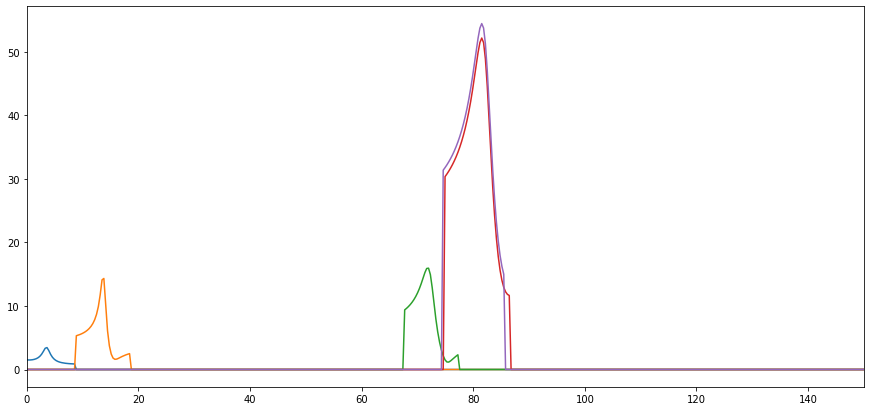

In [46]:
plt.figure(figsize = [15,7])
plt.plot(frequencies,np.abs(H_w_all.transpose()))
plt.xlim(0,150)
# plt.ylim(0,10)
plt.show()

## Task 2: Compute the Mode Shapes

Having obtained natural frequencies and damping factors, from peak-picking (maximum maplitude, quadrature component, ...) use the recepance curves to determine the modal constants and mode shapes.
The mode shapes will be complex valued in ganeral (due to the damping present in the system). As the are complex-valued you can display them as real/imaginary part, or absolute value and phase. Try both!

* Compute and plot the mode shapes from the peak-picking procedure

* Compute and plot the modes from circle fitting

* animate selected mode shapes. What do you observe?

## Ibrahim Time Domain Method

Implement the Ibrahim Time Domain method to use it on the data from the impact hammer experiemnt.
Since the ITD operates on the free oscillation response in terms of the degrees of freedom (displacements in our case) you need to either compute the impulse respone from the accelerance using an inverse FFT or use the provided displacement data in `measurement-ITD.txt`.

* implement the ITD alogithm. Use the following skeleton

```python
def ITD(D,dt=1.0,n1=1,n3=17,tol=1.0):
    """Ibrahim time domain identification alogithm
    
    Parameters
    ----------
    D : array(N,M)
        matrix containing data at N measurement positions
        time sampled at M times
    dt : float
        sampling interval
    n1 : int
        number samples to shift between measurement matrix X1 and
        its time shifted companion X2
    n3 : int
        number samples to shift between upper and lower part of
        X1 and X2, respectively
    tol : float
        tolerance for the MSCCF used to sort out computational modes.
        only modes abs(MSCCF-1)<tol are returned. 
        
    Returns
    -------
    lam : array(K)
        identified eigenvalues, only positive frequencies are returned
    V : array(N,K)
        corresponding eigenvectors
    MSCCF : array(K)
        the mode shape correlation and confidence factor
    """
    
    # 1) determine which samples should be selected in X1 and X2
    Nt = D.shape[1]
    It1 = arange(0,Nt-n3-n1,1)
    # 2) select samples from data matrix
    X1u = D[:,It1] # upper part
    X1l = D[:,It1+n3] # lower part (shifted by n3 samples)
    X2u = D[:,It1+n1] # time shifted companion (shifted by n1 samples)
    X2l = D[:,It1+n1+n3]
    # 3) assmble X1 and X2
    # 4) compute A: use a robust inverse like numpy's linalg.pinv, or solve linear systems
    # 5) solve eigenvalue problem
    # 6) convert eigenvalues
    # 7) compute MSCCF and choose what to return
    
    return lam, V
```

* use the ITD to identify modes from the impulse response. Choose what data to take (which time range is useful?), and what sampling parameters are suitable. Plot the input data over time (all signals in one plot).

* plot the obtained modes and give their natural frequencies, damping factors, and MSCCFs.

## Compare mode shapes

Use the MAC / MSF to compare your identified modes with the deformation modes of the free-free plate.

* Compute the free-free modes and interpolate/evaluate them at the measurement locations.

* Compute the MAC-matrix between the "experimental" modes from peak-picking and the "numeric" free-free modes. Plot the matrix and ude it to identify the best-fitting "experimental" mode for each "numeric" deformation mode.

* Plot the mode shapes of the correlated mode pair to check. Do the frequencies match? Which threshold value of the MAC is suitable to select "correlated" modes?

* Do the same for the modes from circle fitting. Mark the impact location in the plots. Give frequencies and damping ratios, as well as absolute value and phase of the MSF between "numeric" and "experimental" modes.

* Do the same for the modes form the ITD